# Common imports

In [1]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    # filter image
    # filters = ["yaleB07_P00A-110E+40.pgm", "yaleB07_P00A+130E+20", "yaleB07_P00A+110E+65", "yaleB07_P00A-120E+00.pgm", "yaleB07_P00A+095E+00.pgm", "yaleB07_P00A+110E+15.pgm", "yaleB07_P00A-110E-20.pgm", "yaleB07_P00A-085E-20.pgm", "yaleB07_P00A-110E+15.pgm", "yaleB07_P00A+085E+20.pgm", "yaleB07_P00A-095E+00.pgm", "yaleB07_P00A+085E-20.pgm", "yaleB07_P00A+000E+90.pgm", "yaleB07_P00A+110E-20.pgm", "yaleB07_P00A+110E+40.pgm", "yaleB07_P00A+120E+00.pgm", "yaleB07_P00A-110E+65.pgm", "yaleB07_P00A-130E+20.pgm", ]
    filters = ["yaleB05_P00A-095E+00.pgm", "yaleB05_P00A-110E+15.pgm", "yaleB05_P00A+110E-20.pgm", "yaleB05_P00A+000E+90.pgm", "yaleB05_P00A+110E+40.pgm", "yaleB05_P00A-130E+20.pgm", "yaleB05_P00A-110E+65.pgm", "yaleB05_P00A+120E+00.pgm", "yaleB05_P00A-110E+40.pgm", "yaleB05_P00A-120E+00.pgm", "yaleB05_P00A+110E+65.pgm", "yaleB05_P00A+130E+20.pgm", "yaleB05_P00A+110E+15.pgm", "yaleB05_P00A-110E-20.pgm",]
    filtered_list = []
    for img in im_sub_list:
        if not os.path.basename(img) in filters:
            filtered_list.append(img)
    im_sub_list = filtered_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [4]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(40, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [6]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    processed_imarray = imarray - np.expand_dims(ambimage, axis=-1)
    # remove 0
    processed_imarray = np.clip(processed_imarray, 0, 255)
    # rescale
    processed_imarray = processed_imarray / 255
    return processed_imarray

In [40]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    imarray_shape = imarray.shape
    # reshape imarray to (hw, Nimages)
    imarray = np.reshape(imarray, (-1, imarray_shape[-1]))
    # compute inverse of V
    # inv_V = np.linalg.pinv(light_dirs)
    # compute g for each pixel (hw, 3)
    # g = np.matmul(inv_V, imarray.transpose()) # (3, hw)
    g = np.linalg.lstsq(light_dirs, imarray.transpose())[0] # as website
    g = np.reshape(g.transpose(), (imarray_shape[0], imarray_shape[1], 3))
    # compute norm
    fx = np.true_divide(g[:, :, 0], g[:, :, 2], where=g[:,:,2]!=0)
    fy = np.true_divide(g[:, :, 1], g[:, :, 2], where=g[:,:,2]!=0)
    norm = 1/np.sqrt(fx**2+fy**2+1)
    surface_normals = np.stack([fx, fy, np.ones_like(fx)], axis=-1)
    surface_normals = surface_normals * np.expand_dims(norm, axis=-1)
    # compute albedo
    albedo_image = np.linalg.norm(g, axis=-1)
    # check 
    # print(surface_normals * np.expand_dims(albedo_image, axis=-1)-g)
    return albedo_image, surface_normals

In [107]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    def _row_integral(fx, fy):
        tmp = fy.copy()
        tmp[0, :] = np.cumsum(fx[0, :])
        hm = np.cumsum(tmp, axis=0)
        return hm
    
    def _col_integral(fx, fy):
        tmp = fx.copy()
        tmp[:, 0] = np.cumsum(fy[:, 0])
        hm = np.cumsum(tmp, axis=1)
        return hm

    def random_integral(inputs): 
        fx, fy = inputs
        hm = np.zeros_like(fx)
        h, w = fx.shape
        for i in range(h):
            for j in range(w):
                steps = ['v'] * i + ['h'] * j
                # randomize 
                np.random.shuffle(steps)
                xy_sum = fx[0][0] + fy[0][0] # initialize
                x, y = 0, 0
                for s in steps:
                    if s == "v":
                        y += 1
                        xy_sum += fy[y][x]
                    elif s == "h":
                        x += 1
                        xy_sum += fx[y][x]
                hm[i][j] = xy_sum
        return hm
        
    fx = surface_normals[:, :, 0]
    fy = surface_normals[:, :, 1]
    if integration_method == 'column':
        height_map = _row_integral(fx, fy)
    elif integration_method == "row": 
        height_map = _col_integral(fx, fy)
    elif integration_method == 'average':
        hm_row = _row_integral(fx, fy)
        hm_col = _row_integral(fx, fy)
        height_map = (hm_row + hm_col) / 2
    elif integration_method == 'random':
        # from multiprocessing import Pool
        # pool = Pool(8)
        num_trials = 10
        height_maps = np.zeros_like(fx)
        for _ in range(num_trials):
            height_maps += random_integral([fx, fy])
        # height_maps = pool.map(random_integral, [(fx, fy) for _ in range(num_trials)])
        # pool.close()
        # pool.join()
        # height_map = np.sum(height_maps, axis=0) / num_trials
        height_map = height_maps / num_trials
    return height_map

# Main function

In [108]:
root_path = 'croppedyale/'
subject_name = 'yaleB05'
integration_method = 'random'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)
print(ambient_image.shape, imarray.shape, light_dirs.shape)
processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)
height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

(192, 168) (192, 168, 50) (50, 3)


/Users/zongfan/opt/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


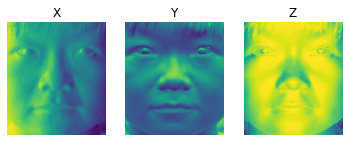

In [273]:
plot_surface_normals(surface_normals)

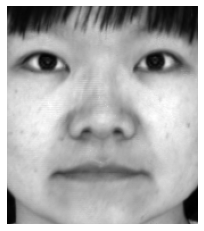

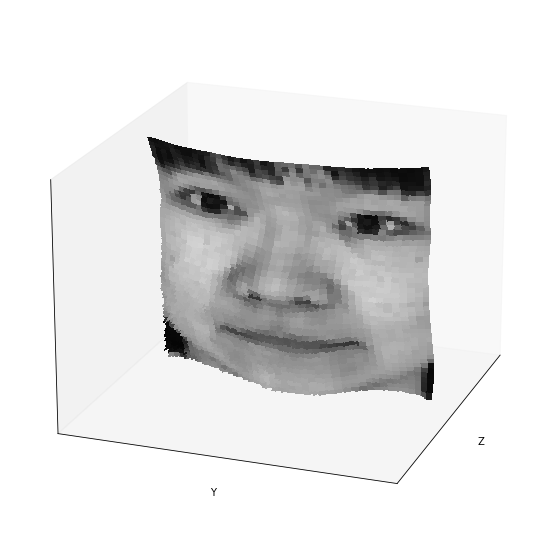

In [109]:
display_output(albedo_image, height_map)

In [125]:
# Phantom 3D model data to test the accuracy of surface normal estimation 
def LoadDiLiGenTImages(full_path, subject_name, num_images=96):
    # crop background
    h_up, h_bottom = 70, 380
    w_left, w_right = 200, 500
    def load_image(fname, ints):
        image = np.asarray(Image.open(fname))
        # each color channel should be normalized with intensity
        ints = np.array([[ints]])
        image = image / ints
        image = image.astype(np.uint8)
        gray = np.asarray(Image.fromarray(image).convert("L"))
        # gray = np.asarray(Image.open(fname).convert("L"))
        gray = gray[h_up:h_bottom, w_left:w_right]
        return gray

    def load_light_direction_intensity(fname):
        data = []
        with open(fname, "r") as f:
            for l in f:
                dirs = [float(f) for f in l.strip().split(" ")]
                data.append(dirs)
        f.close()
        return np.array(data)

    def load_normal(mat_file):
        from scipy.io import loadmat
        data = loadmat(mat_file)
        normal = data["Normal_gt"]
        normal = normal[h_up:h_bottom, w_left:w_right]
        normal[:, :, 2] = 1
        return normal

    # load intensity for normalizing image values
    ints_file = os.path.join(full_path, subject_name, "light_intensities.txt")
    lightints = load_light_direction_intensity(ints_file)
    # load mask which is used to mask out non-object regions
    mask_file = os.path.join(full_path, subject_name, "mask.png")
    mask = np.asarray(Image.open(mask_file).convert("L")) / 255
    mask = mask[h_up:h_bottom, w_left:w_right]
    # load images
    im_list = [os.path.join(full_path, subject_name, "{:03d}.png".format(i)) for i in range(1, num_images+1)]
    imarray = np.stack([load_image(im_list[i], lightints[i])*mask for i in range(num_images)], axis=-1)
    # load directions 
    dir_file = os.path.join(full_path, subject_name, "light_directions.txt")
    light_dirs = load_light_direction_intensity(dir_file)
    # change xyz to yzx
    # light_dirs_cp =  light_dirs.copy()
    # light_dirs = light_dirs_cp[:, [0, 2, 1]]
    # load normal_gt 
    gt_file = os.path.join(full_path, subject_name, "Normal_gt.mat")
    normal_gt = load_normal(gt_file)
    # set ambient bg as black
    img_h, img_w, _ = imarray.shape 
    ambient = np.zeros((img_h, img_w)).astype(np.float)
    return ambient, imarray, light_dirs, normal_gt

/Users/zongfan/opt/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


squared difference between predicted Normal and GT Normal:  6921.343864143864


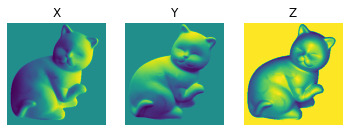

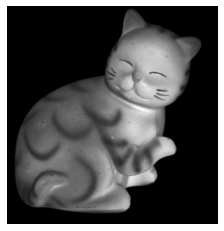

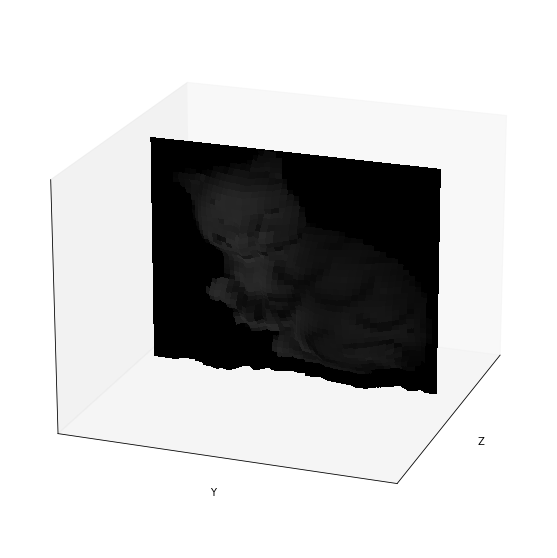

In [126]:
root_path = '/Users/zongfan/Downloads/DiLiGenT/pmsData'
subject_name = 'catPNG'
integration_method = 'average'
save_flag = True

ambient_image, imarray, light_dirs, normal_gt = LoadDiLiGenTImages(root_path, subject_name, 96)
# print(imarray.shape, light_dirs.shape, normal_gt.shape)
processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)
# compute loss between prediction and gt with L2
diff = np.square(surface_normals - normal_gt).sum()
print("squared difference between predicted Normal and GT Normal: ", diff)
height_map = get_surface(surface_normals, integration_method)

if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)
plot_surface_normals(surface_normals)
display_output(albedo_image, height_map)